## Statistics Report (MECD - FEUP)
Fundamentos de Ciência e Engenharia dos Dados
 

Group 6: Henrique Ribeiro, Rojan Aslani, Sónia Ferreira 

October 2022

`-->Research Question:`
Compare response, extinction time and cause of the wildfires, to see the influence on the burn areas for districts of Braga and Santarém.

`-->Qualitative variables`

Distrito (Braga; Santarém)

Cause (Uso de fogo; Incendiarismo)
 
`-->Quantitative variables`

ResponseTime (HoraAlerta - Hora1Intervencao)

ExtinctionTime (Hora1Intervencao - HoraExtincao)

AA_Total

In [1]:
%reset -f

#### Import datasets

The dataset of this study were obtained from the official file of all wildfires of portugal in 2015. The dataset was "cleaned" based on the conclusions taken during the data exploration step and 2 files were generated with data regrading wildfires of Braga and Santarem districts, cause by (1) use of fire and (2) Fire.

In [2]:
from ctypes import sizeof
from calendar import c

from dataclasses import replace
from __future__ import print_function, division

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numpy as np
from numpy import cov

import pandas as pd

from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm

# Import datasets of chosen districts
# Braga 
district1 = 'Braga'
io1 = district1 + '.xlsx'
dataset1 = pd.read_excel(io1, district1, header=0) 

# Santarem
district2 = 'Santarém'
io2 = district2 + '.xlsx'
dataset2 = pd.read_excel(io2, district2, header=0) 


In [3]:
# Changing column names 
dataset1.rename(columns={'AA_Total (pov+mato+agric) (ha)':'TotalArea'}, inplace = True)
dataset2.rename(columns={'AA_Total (pov+mato+agric) (ha)':'TotalArea'}, inplace = True)

# Adding column for district code
dataset1['District'] = 1
dataset2['District'] = 2


#### STEP 3: Data Exploration

##### Dataframe information

In [4]:
#datasets sizes
print(district1 , dataset1.shape)
print(district2 , dataset2.shape)

Braga (952, 5)
Santarém (689, 5)


In [5]:
#columns data type
dataset1.dtypes

Cause                    int64
InterventionTimeMin      int64
ExtinctionTimeMin        int64
TotalArea              float64
District                 int64
dtype: object

In [6]:
# Number of cases of fire for each cause in Santarem
dataset2.groupby(dataset2['Cause']).size()

Cause
1    400
4    289
dtype: int64

In [7]:
print(district1)
dataset1.describe()

Braga


,Cause,InterventionTimeMin,ExtinctionTimeMin,TotalArea,District
count,952.000000,952.000000,952.000000,952.000000,952.0
mean,1.633403,13.153361,156.433824,3.341241,1.0
std,1.224984,8.890360,210.972516,11.873399,0.0
min,1.000000,2.000000,10.000000,0.000000,1.0
25%,1.000000,8.000000,70.000000,0.050000,1.0
50%,1.000000,12.000000,110.000000,0.450000,1.0
75%,1.000000,16.000000,175.000000,1.757500,1.0
max,4.000000,152.000000,3260.000000,143.000000,1.0


In [8]:
print(district2)
dataset2.describe()

Santarém


,Cause,InterventionTimeMin,ExtinctionTimeMin,TotalArea,District
count,689.000000,689.000000,689.000000,689.000000,689.0
mean,2.258345,12.288824,93.483309,3.629433,2.0
std,1.481482,7.610382,122.317615,60.780020,0.0
min,1.000000,2.000000,7.000000,0.000100,2.0
25%,1.000000,7.000000,42.000000,0.015800,2.0
50%,1.000000,11.000000,68.000000,0.067000,2.0
75%,4.000000,16.000000,109.000000,0.313200,2.0
max,4.000000,44.000000,2096.000000,1580.000000,2.0


##### Removing outliers from the datasets

Outliers were considered data that are more than 2 standard deviations above the average, and less than 1 standard deviation below the average.  

In [9]:
#dataset1
dataset1_noout = dataset1 [(np.abs(stats.zscore(dataset1[['ExtinctionTimeMin', 'InterventionTimeMin', 'TotalArea']]) <2)).all(axis=1)]
rem1 = dataset1.shape[0] - dataset1_noout.shape[0]
per1 = round(rem1/len(dataset1)*100)
print('Number of outliers removed from', district1, ': ' ,rem1, 'rows (', per1,'%).' )

#dataset2 
dataset2_noout = dataset2 [(np.abs(stats.zscore(dataset2[['ExtinctionTimeMin', 'InterventionTimeMin', 'TotalArea']]) <2)).all(axis=1)]
dataset2_noout.drop(dataset2_noout[(dataset2_noout['TotalArea'] > 80)].index, inplace=True)
rem2 = dataset2.shape[0] - dataset2_noout.shape[0]
per2 = round(rem2/len(dataset2)*100)
print('Number of outliers removed from', district2, ': ' ,rem2, 'rows (', per2,'%).' )


Number of outliers removed from Braga :  65 rows ( 7 %).
Number of outliers removed from Santarém :  45 rows ( 7 %).


C:\Users\aslan\AppData\Local\Temp\ipykernel_9960\3273353170.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset2_noout.drop(dataset2_noout[(dataset2_noout['TotalArea'] > 80)].index, inplace=True)


In [10]:
#The mean difference between extintion time (min) of the two districts with and without outliers
print('The mean difference with outliers is: %4.2f.' % abs (dataset1['ExtinctionTimeMin'].mean() - dataset2['ExtinctionTimeMin'].mean()))
print("The mean difference without outliers is: %4.2f." % abs (dataset1_noout['ExtinctionTimeMin'].mean() - dataset2_noout['ExtinctionTimeMin'].mean()))

The mean difference with outliers is: 62.95.
The mean difference without outliers is: 46.07.


Text(0.5, 0, 'Samples (Braga)')

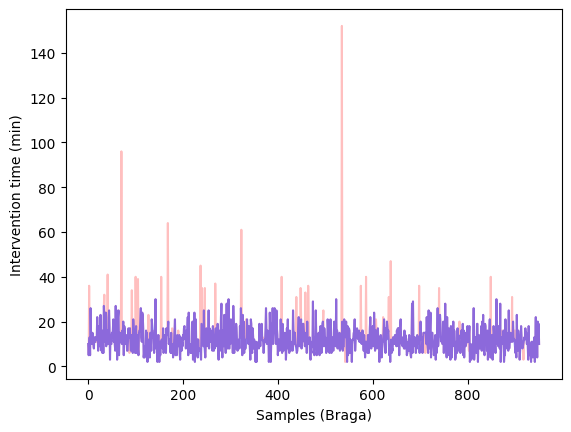

In [11]:
dataset1.InterventionTimeMin.plot(alpha=.25, color='red')
dataset1_noout.InterventionTimeMin.plot(alpha=.45,color='blue')

plt.ylabel('Intervention time (min)')
plt.xlabel('Samples (Braga)')

Text(0.5, 0, 'Samples (Santarem)')

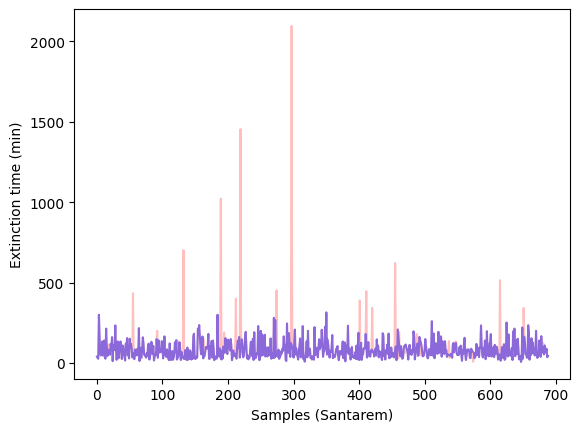

In [12]:
# ExtinctionTime outliers of Santarem
dataset2.ExtinctionTimeMin.plot(alpha=.25, color='red')
dataset2_noout.ExtinctionTimeMin.plot(alpha=.45,color='blue')

plt.ylabel('Extinction time (min)')
plt.xlabel('Samples (Santarem)')

In [13]:
# Creating one database with all the data
df_all_cols = pd.concat([dataset1_noout, dataset2_noout], axis = 0)

##### Data Exploration - with graphs

##### Each district individually

Braga


array([[<AxesSubplot: title={'center': 'TotalArea'}>,
        <AxesSubplot: title={'center': 'InterventionTimeMin'}>],
       [<AxesSubplot: title={'center': 'ExtinctionTimeMin'}>,
        <AxesSubplot: title={'center': 'Cause'}>]], dtype=object)

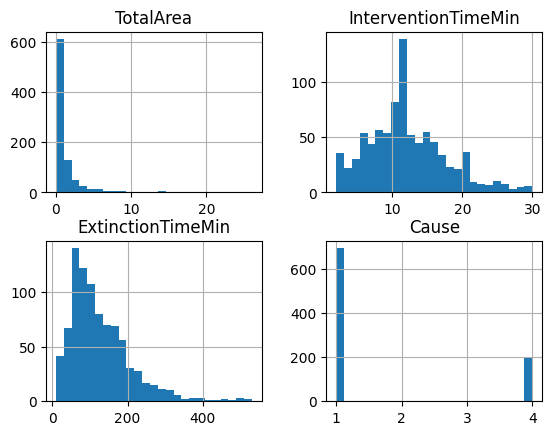

In [14]:
print(district1)
dataset1_noout[['TotalArea', 'InterventionTimeMin','ExtinctionTimeMin', 'Cause']].hist(density=False, histtype='stepfilled', bins=25)

Santarém


array([[<AxesSubplot: title={'center': 'TotalArea'}>,
        <AxesSubplot: title={'center': 'InterventionTimeMin'}>],
       [<AxesSubplot: title={'center': 'ExtinctionTimeMin'}>,
        <AxesSubplot: title={'center': 'Cause'}>]], dtype=object)

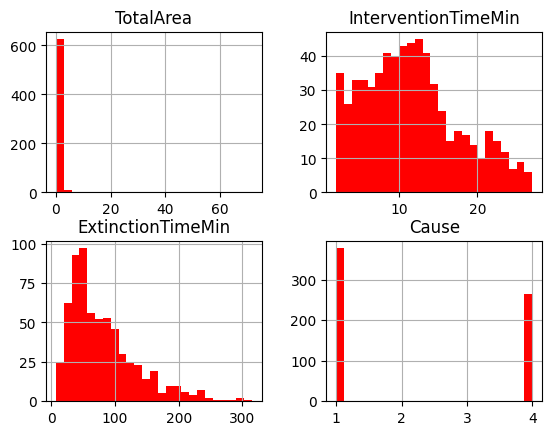

In [15]:
print(district2)
dataset2_noout[['TotalArea', 'InterventionTimeMin','ExtinctionTimeMin', 'Cause']].hist(density=False, histtype='stepfilled', bins=25, color='r')

{'whiskers': [<matplotlib.lines.Line2D at 0x1ff96cd54e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ff96cd5a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ff96cd5240>],
 'medians': [<matplotlib.lines.Line2D at 0x1ff96cd5f60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ff96cd6200>],
 'means': []}

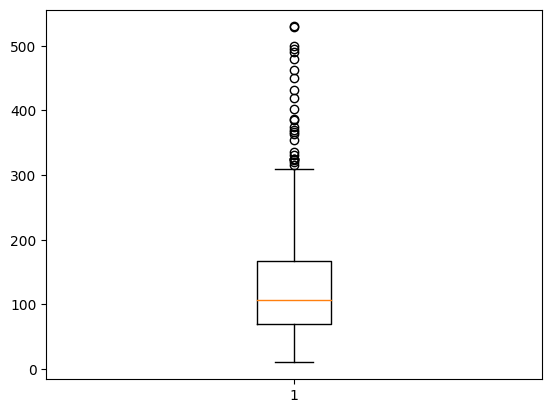

In [16]:
plt.boxplot(dataset1_noout['ExtinctionTimeMin'], notch=None, vert=None, patch_artist=None, widths=None)

##### Comparison of 2 districts

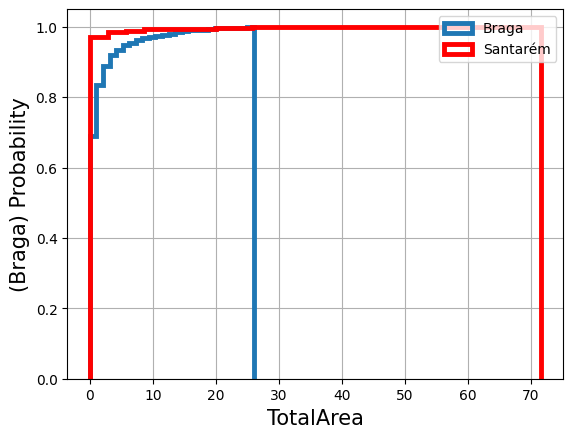

In [17]:
dataset1_noout['TotalArea'].hist(density=True, histtype='step', cumulative=True, linewidth=3.5, bins=25)
dataset2_noout['TotalArea'].hist(density=True, histtype='step', cumulative=True, linewidth=3.5, bins=25 , color='r')

labels = [district1, district2]
plt.legend(labels)
plt.xlabel('TotalArea',fontsize=15)
plt.ylabel('('+district1 +')' +' Probability',fontsize=15)

plt.show()

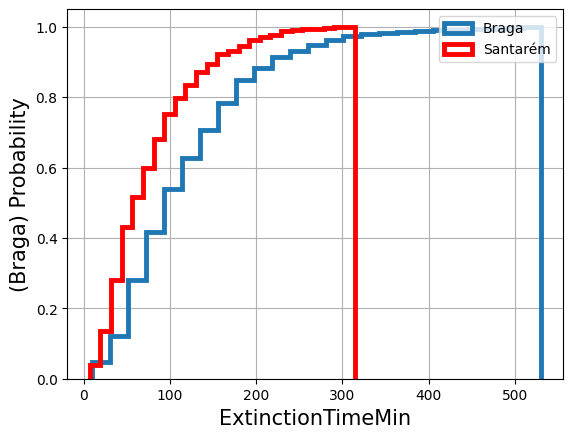

In [18]:
dataset1_noout['ExtinctionTimeMin'].hist(density=True, histtype='step', cumulative=True, linewidth=3.5, bins=25)
dataset2_noout['ExtinctionTimeMin'].hist(density=True, histtype='step', cumulative=True, linewidth=3.5, bins=25 , color='r')

labels = [district1, district2]
plt.legend(labels)
plt.xlabel('ExtinctionTimeMin',fontsize=15)
plt.ylabel('('+district1 +')' +' Probability',fontsize=15)

plt.show()

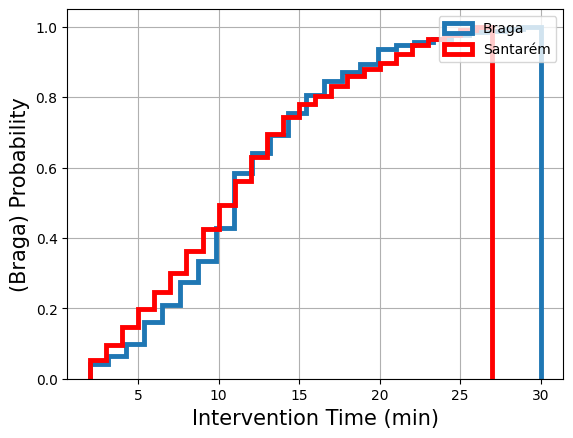

In [19]:
dataset1_noout['InterventionTimeMin'].hist(density=True, histtype='step', cumulative=True, linewidth=3.5, bins=25)
dataset2_noout['InterventionTimeMin'].hist(density=True, histtype='step', cumulative=True, linewidth=3.5, bins=25, color='r')

labels = [district1, district2]
plt.legend(labels)
plt.xlabel('Intervention Time (min)',fontsize=15)
plt.ylabel('('+district1 +') Probability',fontsize=15)

plt.show()

<AxesSubplot: xlabel='TotalArea', ylabel='Density'>

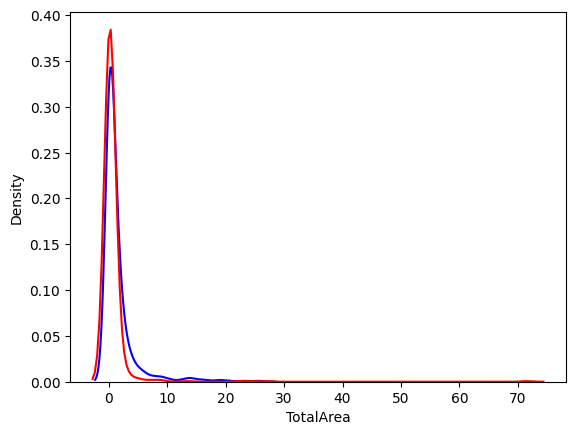

In [20]:
# density plot
sns.kdeplot(dataset1_noout['TotalArea'], color='blue')
sns.kdeplot(dataset2_noout['TotalArea'], color='red')

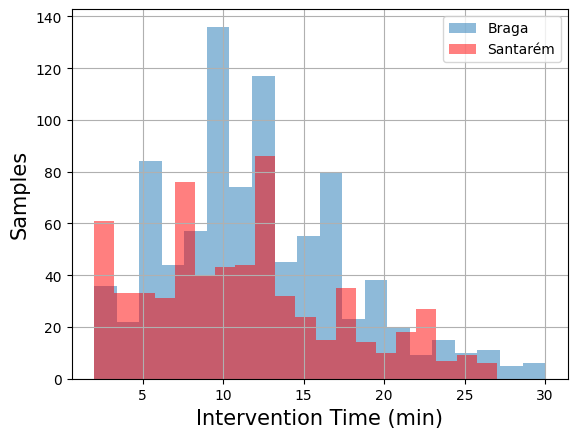

In [21]:
ds1_intervention_time = dataset1_noout['InterventionTimeMin']
ds2_intervention_time = dataset2_noout['InterventionTimeMin']

ds1_intervention_time.hist(density=False, histtype='stepfilled', alpha=.5, bins=20)   # default number of bins = 10
ds2_intervention_time.hist(density=False, histtype='stepfilled', alpha=.5, color='r', bins=20)

labels = [district1, district2]
plt.legend(labels)
plt.xlabel('Intervention Time (min)',fontsize=15)
plt.ylabel('Samples',fontsize=15)
plt.show()


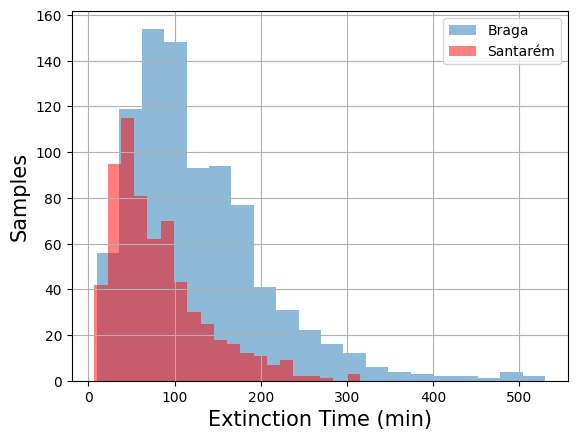

In [22]:
ds1_extinction_time = dataset1_noout['ExtinctionTimeMin']
ds2_extinction_time = dataset2_noout['ExtinctionTimeMin']

ds1_extinction_time.hist(density=False, histtype='stepfilled', alpha=.5, bins=20) 
ds2_extinction_time.hist(density=False, histtype='stepfilled', alpha=.5,color='r', bins=20)

labels = [district1, district2]
plt.legend(labels)

plt.xlabel('Extinction Time (min)',fontsize=15)
plt.ylabel('Samples',fontsize=15)
plt.show()

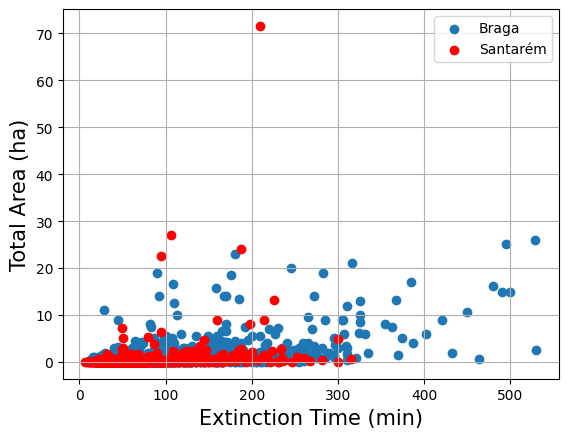

In [23]:
plt.scatter(dataset1_noout['ExtinctionTimeMin'], dataset1_noout['TotalArea'])
plt.scatter(dataset2_noout['ExtinctionTimeMin'], dataset2_noout['TotalArea'], color='r')

labels = [district1, district2]
plt.legend(labels)
plt.xlabel('Extinction Time (min)',fontsize=15)
plt.ylabel('Total Area (ha)',fontsize=15)
plt.grid(True)

plt.show()

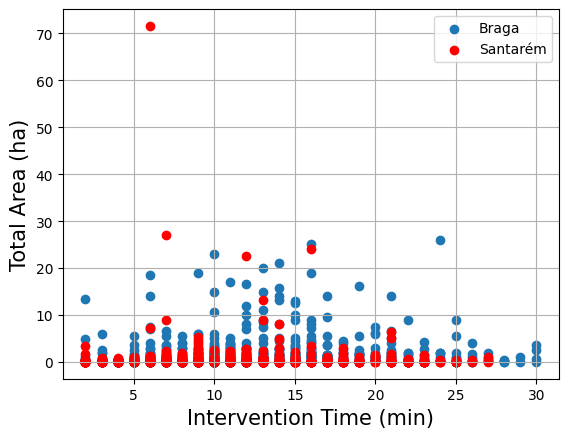

In [24]:
plt.scatter(dataset1_noout['InterventionTimeMin'], dataset1_noout['TotalArea'])
plt.scatter(dataset2_noout['InterventionTimeMin'], dataset2_noout['TotalArea'], color='r')

labels = [district1, district2]
plt.legend(labels)
plt.xlabel('Intervention Time (min)',fontsize=15)
plt.ylabel('Total Area (ha)',fontsize=15)
plt.grid(True)

plt.show()

##### Comparison of 3 quantitative values

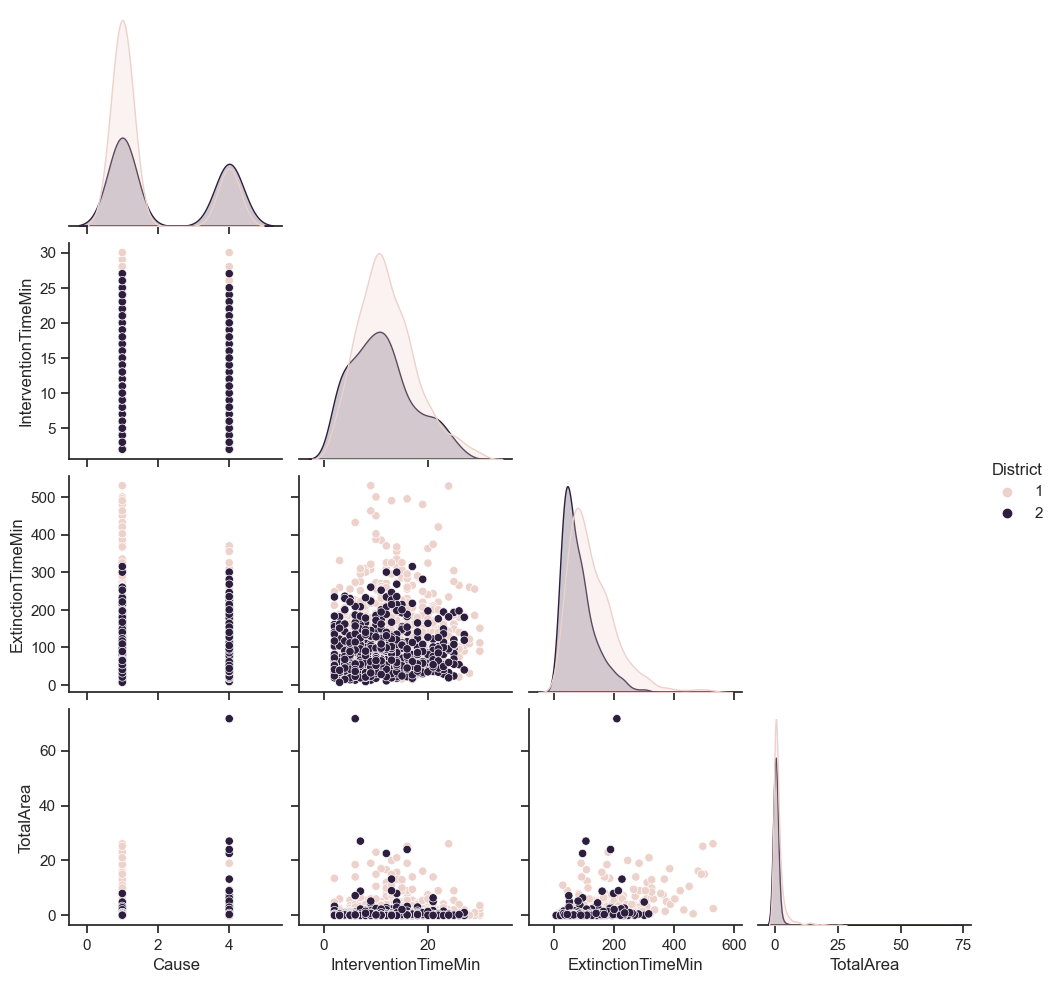

In [25]:
sns.set_theme(style="ticks")
sns.pairplot(df_all_cols, hue="District", corner=True)

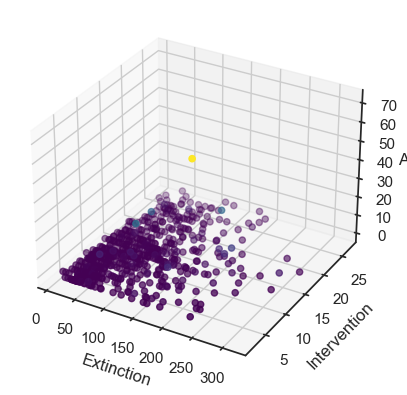

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
Z = dataset2_noout['TotalArea']
X = dataset2_noout['ExtinctionTimeMin']
Y = dataset2_noout['InterventionTimeMin']

# Data for three-dimensional scattered points
ax.scatter(X, Y, Z, c=Z, cmap='viridis');
ax.set_xlabel('Extinction')
ax.set_ylabel('Intervention')
ax.set_zlabel('Area');

#### STEP 4: Draw inferences

##### QUESTION 1: Does the cause of fire impact the burnt area of the district?

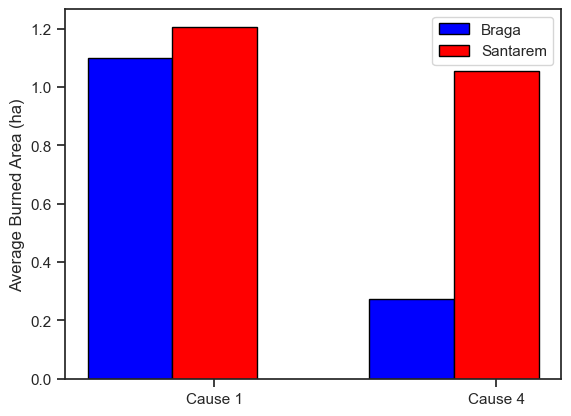

In [27]:
# Relation between average burnt area and cause of fire (for both districts)
ds11 = df_all_cols[df_all_cols['Cause']==1] #n=717
aam11 = ds11['TotalArea'].mean()
aastd11 =  abs(ds11['TotalArea'].max()-ds11['TotalArea'].min())

ds14 = dataset1_noout[dataset1_noout['Cause']==4] #n=194
aam14 = ds14['TotalArea'].mean()
aastd14 =  abs(ds14['TotalArea'].max()-ds14['TotalArea'].min())

ds21 = dataset2_noout[dataset2_noout['Cause']==1] #n=393
aam21 = ds21['TotalArea'].mean()
aastd21 =  abs(ds21['TotalArea'].max()-ds21['TotalArea'].min())

ds24 = dataset2_noout[dataset2_noout['Cause']==4] #n=280
aam24 = ds24['TotalArea'].mean()
aastd24 = abs(ds24['TotalArea'].max()-ds24['TotalArea'].min())

# Y = Averages
bars1 = [aam11, aam21] 
bars2 = [aam14, aam24]
 
# Choose the height of the error bars (bars1) - max-min
yer1 = [aastd11, aastd21]
yer2 = [aastd21, aastd24]
 
# The x position of bars
barWidth = 0.3
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
#plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Braga')
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Braga')
plt.bar(r2, bars2, width = barWidth, color = 'red', edgecolor = 'black',  capsize=7, label='Santarem')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Cause 1', 'Cause 4'])
plt.ylabel('Average Burned Area (ha)')
plt.legend()
plt.show()

In [28]:
x = df_all_cols['TotalArea']
confidence = 0.95

print(x.mean())
values = [np.random.choice(x,size=len(x),replace=True).mean() for i in range(1000)] 
np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)]) 

1.1058097681254082


array([0.95956233, 1.27765902])

T-TEST

For each district:

H0 = there is no association between mean burnt area and the cause of fire (in all districts)

Ha = there is an association between mean burnt area and the cause of fire


In [29]:
# Defining some functions 
def find_pvalue_by_means(group1, group2):
    actual = TestStatistic((group1, group2))

    n, m = len(group1), len(group2)
    pool = np.hstack((group1, group2))

    test_stats = np.array([TestStatistic(RunModel(pool,n)) for i in range(1000)])

    pvalue = sum(test_stats >= actual) / len(test_stats)
    print('pvalue= ',pvalue)

    plt.axvline(actual, linewidth=3, color='0.8')
    plt.hist(test_stats, color='r')
    plt.xlabel('difference in means')
    plt.ylabel('count')
    None
    return pvalue

def TestStatistic(data):
    group1, group2 = data
    test_stat = abs(group1.mean() - group2.mean())
    return test_stat

def RunModel(pool,n):
    np.random.shuffle(pool)
    data = pool[:n], pool[n:]
    return data

def pearson_samples(df1, df2, s): 
    pearsons = 0
    m=1000
    for i in range(m): 
        d1_random = df1.sample(n = s, replace = True)
        d2_random = df2.sample(n = s, replace = True)
        corr, _ = stats.pearsonr(d1_random, d2_random)
        pearsons = corr + pearsons
    p_final = pearsons/m
    return p_final

def TestStatisticR(data):
    group1, group2 = data
    correlation_matrix = np.corrcoef(group1, group2)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy
    test_stat = r_squared
    return test_stat

def RunModelR():
    pool3=group1.sample(frac=1)
    pool4=group2.sample(frac=1)
    pool = np.hstack((pool3, pool4))
    data = pool[:n], pool[n:]
    return data
    

pvalue=  0.182


0.182

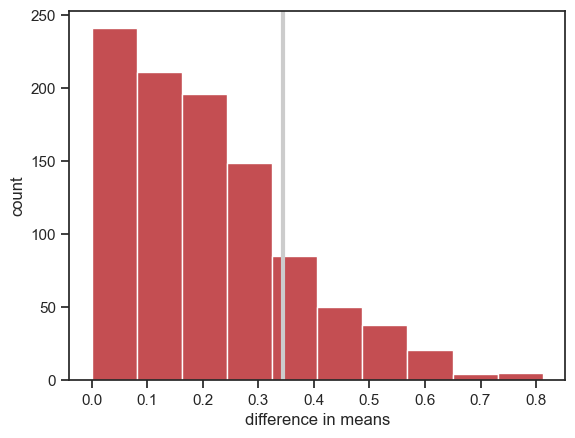

In [30]:
# Braga
c11 = dataset1_noout[dataset1_noout['Cause']==1]
c41 = dataset1_noout[dataset1_noout['Cause']==4]
aac11 = c11['TotalArea']
aac41 = c41['TotalArea']
find_pvalue_by_means(aac11, aac41)
#

pvalue=  0.0


0.0

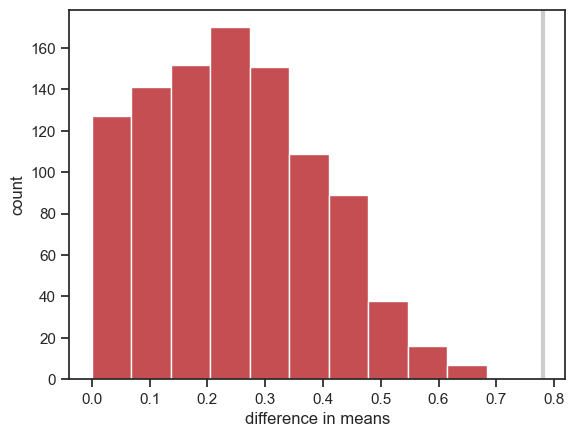

In [31]:
# Santarem
c12 = dataset2_noout[dataset2_noout['Cause']==1]
c42 = dataset2_noout[dataset2_noout['Cause']==4]
aac12 = c12['TotalArea']
aac42 = c42['TotalArea']
find_pvalue_by_means(aac12, aac42)

# the pvalue is high for both cases: there is no association between cause and average burnt area for the districts

In Santarem the p-value is less than 5% (significance level), which means that H0 is rejected.
Hence, the results are in favor of HA - there might be an association between burnt area and cause of fire. 

On the other hand, in Braga the p-value is more than 5% (around 15%), which means that H0 can not be rejected. Hence, Twe cannot make any conclusions regarding the association between these two variables.

##### QUESTION 2. Does the intervention time impact the burnt area?


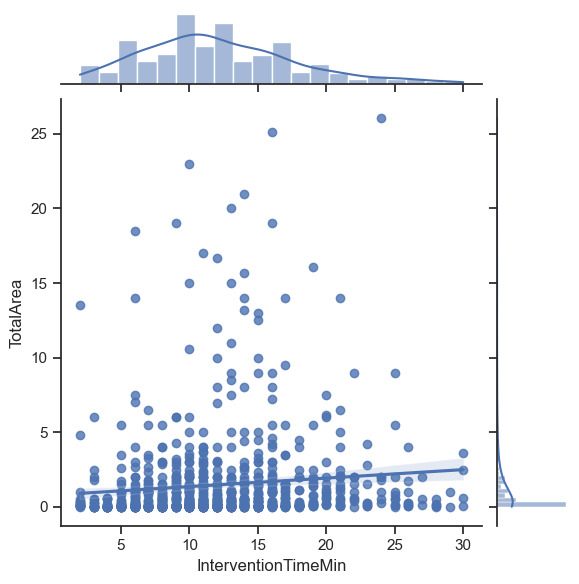

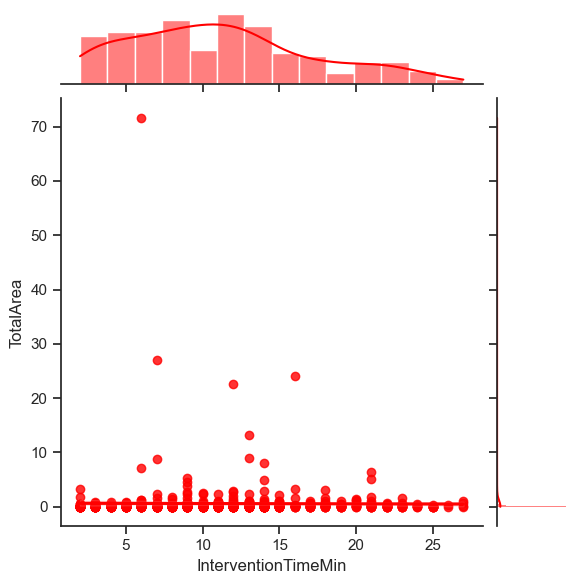

In [32]:
sns.jointplot(x="InterventionTimeMin", y="TotalArea", data=dataset1_noout, kind="reg");
sns.jointplot(x="InterventionTimeMin", y="TotalArea", data=dataset2_noout, kind="reg", color="red");

Covariance

In [33]:
# Covarianve between total Area and intervention time for Braga
aa = dataset1_noout['TotalArea']
bb = dataset1_noout['InterventionTimeMin'] # Cause , ExtinctionTimeMin , InterventionTimeMin

covariance_1 = cov(aa, bb)
print(district1, ': Total Area vs Intervention Time Covariance')
print(covariance_1)

Braga : Total Area vs Intervention Time Covariance
[[ 9.52163989  1.78454716]
 [ 1.78454716 31.38870467]]


In [34]:
# Covarianve between total Area and intervention time for Santarem
cc = dataset2_noout['TotalArea']
dd = dataset2_noout['InterventionTimeMin'] # Cause , ExtinctionTimeMin , InterventionTimeMin

covariance_2 = cov(cc, dd)
print(district2, ': Total Area vs Intervention Time Covariance')
print(covariance_2)

Santarém : Total Area vs Intervention Time Covariance
[[11.68143168 -0.19297749]
 [-0.19297749 36.3790945 ]]


Pearson's correlation

In [35]:
# calculate Pearson's correlation for Braga
corr, _ = pearsonr(dataset1_noout['TotalArea'], dataset1_noout['InterventionTimeMin'])
print('Pearsons correlation for Braga: %.2f' % corr)

# calculate Pearson's correlation for Santarem
corr, _ = pearsonr(dataset2_noout['TotalArea'], dataset2_noout['InterventionTimeMin'])
print('Pearsons correlation for Santarém: %.2f' % corr)

Pearsons correlation for Braga: 0.10
Pearsons correlation for Santarém: -0.01


Braga: 0.10 - Indicates a minimal positive correlation between Intervention Time and Burnt Area.

Santarém: 0.01 - Pearson's correlation coefficient is so low that we can assume that there is no correlation between Intervention Time and Burnt Area. 

In [36]:
#pearson_samples(dataset1_noout['TotalArea'], dataset1_noout['InterventionTimeMin'], 50)
pearson_samples(dataset2_noout['TotalArea'], dataset2_noout['InterventionTimeMin'], 50)

-0.0036026667649464235

##### QUESTION 3. Does the extinction time impact the burnt area?

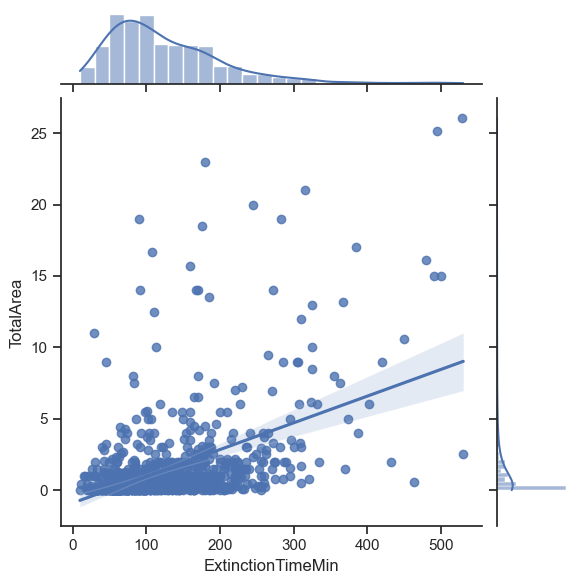

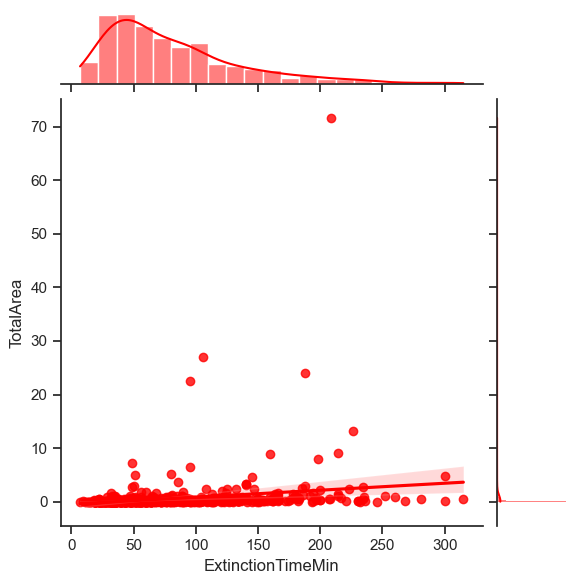

In [37]:
sns.jointplot(x="ExtinctionTimeMin", y="TotalArea", data=dataset1_noout, kind="reg");
sns.jointplot(x="ExtinctionTimeMin", y="TotalArea", data=dataset2_noout, kind="reg", color="red");

H0 : There is no relationship between extinction time and burned area.

Ha : There is a relationship between extinction time and burned area.

pvalue=  0.0


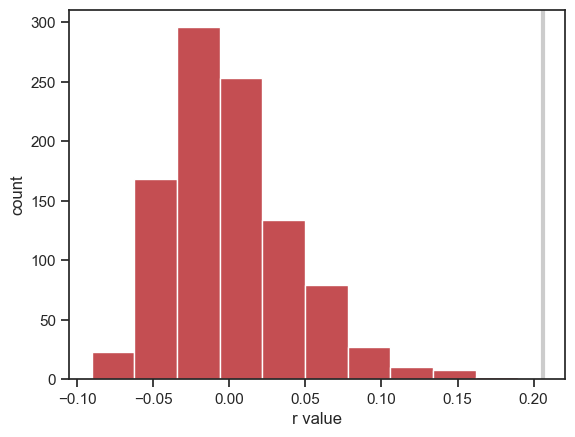

In [38]:
group1 = dataset2_noout['ExtinctionTimeMin']
group2 = dataset2_noout['TotalArea']

actual = TestStatisticR((group1, group2))

n, m = len(group1), len(group2)

test_stats = np.array([TestStatisticR(RunModelR()) for i in range(1000)])

pvalue = sum(test_stats >= actual) / len(test_stats)
print('pvalue= ',pvalue)

plt.axvline(actual, linewidth=3, color='0.8')
plt.hist(test_stats, color='r')
plt.xlabel('r value')
plt.ylabel('count')
None

The p-value for r coefficient is 0, which rejects H0. 

Covarianve

In [39]:
# Covarianve between total population Area and extinction time for Braga
aa = dataset1_noout['TotalArea']
bb = dataset1_noout['ExtinctionTimeMin'] # Cause , ExtinctionTimeMin , InterventionTimeMin

covariance = cov(aa, bb)

print(district1, ': Total Area vs Extinction Time Covariance')
print(covariance)

Braga : Total Area vs Extinction Time Covariance
[[   9.52163989  122.37250194]
 [ 122.37250194 6534.22590923]]


In [40]:
# Covarianve between total population Area and extinction time for Santarem
aa = dataset2_noout['TotalArea']
bb = dataset2_noout['ExtinctionTimeMin'] # Cause , ExtinctionTimeMin , InterventionTimeMin

covariance = cov(aa, bb)

print(district2, ': Total Area vs Extinction Time Covariance')
print(covariance)

Santarém : Total Area vs Extinction Time Covariance
[[  11.68143168   38.12993736]
 [  38.12993736 2933.19278566]]


In [41]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dataset1_noout['TotalArea'], dataset1_noout['ExtinctionTimeMin'])
print(r_value)

corr, _ = pearsonr(dataset1_noout['TotalArea'], dataset1_noout['ExtinctionTimeMin'])
print('Pearsons correlation for Braga: %.2f' % corr)

corr, _ = pearsonr(dataset2_noout['TotalArea'], dataset2_noout['ExtinctionTimeMin'])
print('Pearsons correlation for Santarem: %.2f' % corr)

0.49060378050076464
Pearsons correlation for Braga: 0.49
Pearsons correlation for Santarem: 0.21


Braga: 0.49 - Indicates a moderately positive correlation between Extinction Time and Burnt Area - the extinction time impacts the Burnt Area 

Santarém: 0.16 - Indicates a low positive correlation between Extinction Time and Burnt Area - the extinction time impacts the burnt area.

##### Prediction system of burned area (ha) according to time of intervention and time of extinction  

Multiple Regression

In [42]:
X = dataset2_noout[['ExtinctionTimeMin', 'InterventionTimeMin']]
y = dataset2_noout['TotalArea']

regr = linear_model.LinearRegression()
a = regr.fit(X, y)

# for Braga the predicted fire for its 0.57 ha and for Santarem its 0.77 ha !!

itmin = 10
etmin = 80
predictedAA = regr.predict([[etmin, itmin]])

print('Extinction time (min):',etmin)
print('Intervention time (min):',itmin)
print('predicted burned area (he):',predictedAA)


Extinction time (min): 80
Intervention time (min): 10
predicted burned area (he): [0.60781593]


C:\Users\aslan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Multiple Linear Regression 

In [43]:
x = dataset2_noout[['ExtinctionTimeMin', 'InterventionTimeMin']]
y = dataset2_noout['TotalArea']

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              TotalArea   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     14.65
Date:                Fri, 14 Oct 2022   Prob (F-statistic):           6.01e-07
Time:                        10:52:51   Log-Likelihood:                -1690.4
No. Observations:                 644   AIC:                             3387.
Df Residuals:                     641   BIC:                             3400.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2510    